## Multifunctional NLP and Image Generation Tool using Hugging Face Models

## Text summarization 

In [1]:
from transformers import BartForConditionalGeneration, BartTokenizer
import torch

# Load pre-trained model and tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

def summarize(text, model, tokenizer, max_length=130, min_length=30, do_sample=False):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example text
text = """
Hugging Face Inc. is a company that develops tools for building applications using machine learning. Its headquarters are in New York City.
It was founded in 2016 by Clement Delangue, Julien Chaumond, and Thomas Wolf. Initially, Hugging Face created a chatbot app targeted at teenagers.
In 2019, Hugging Face transformed into an open-source provider of NLP technologies.
Its model library, Transformers, became widely used in both academia and industry,
garnering significant attention for its implementation of state-of-the-art NLP models.
"""

# Perform summarization
summary = summarize(text, model, tokenizer)
print("Original text:\n", text)
print("\nSummary:\n", summary)

Original text:
 
Hugging Face Inc. is a company that develops tools for building applications using machine learning. Its headquarters are in New York City.
It was founded in 2016 by Clement Delangue, Julien Chaumond, and Thomas Wolf. Initially, Hugging Face created a chatbot app targeted at teenagers.
In 2019, Hugging Face transformed into an open-source provider of NLP technologies.
Its model library, Transformers, became widely used in both academia and industry,
garnering significant attention for its implementation of state-of-the-art NLP models.


Summary:
 Hugging Face was founded in 2016 by Clement Delangue, Julien Chaumond, and Thomas Wolf. In 2019, Hugging Face transformed into an open-source provider of NLP technologies. Its model library, Transformers, became widely used in both academia and industry.


## Next word prediction -GPT 2

In [2]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Set the model to evaluation mode
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
import torch

def predict_next_word(prompt, model, tokenizer, top_k=5):
    # Tokenize input text
    inputs = tokenizer(prompt, return_tensors='pt')

    # Generate predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits of the last token in the sequence
    next_token_logits = outputs.logits[:, -1, :]

    # Filter the top k tokens by their probability
    top_k_tokens = torch.topk(next_token_logits, top_k).indices[0].tolist()

    # Decode the top k tokens to their corresponding words
    predicted_tokens = [tokenizer.decode([token]) for token in top_k_tokens]

    return predicted_tokens

# Example usage
prompt = "The poor girl was in a village and"
predicted_words = predict_next_word(prompt, model, tokenizer)
print(f"Prompt: {prompt}")
print(f"Next word predictions: {predicted_words}")

Prompt: The poor girl was in a village and
Next word predictions: [' she', ' had', ' was', ' the', ' her']


## Generating story with GPT 2

In [4]:
def generate_text(prompt, model, tokenizer, max_length=50):
    generated = tokenizer.encode(prompt, return_tensors='pt')

    model.eval()
    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(generated)
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1)
            generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
            if next_token == tokenizer.eos_token_id:
                break

    return tokenizer.decode(generated[0], skip_special_tokens=True)

# Example usage
prompt = "The poor girl was in a village and"
generated_text = generate_text(prompt, model, tokenizer)
print(f"Generated text: {generated_text}")

Generated text: The poor girl was in a village and she was being treated for a broken leg. She was taken to the hospital and then taken to the hospital for treatment. She was taken to the hospital for treatment. She was taken to the hospital for treatment. She was taken to the hospital for treatment


## Chat bot with GPT 2

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load pre-trained model and tokenizer with padding set to left
model_name = "microsoft/DialoGPT-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

def chat_with_model(prompt, chat_history_ids, model, tokenizer):
    # Encode the new user input, add the eos_token and return a tensor in PyTorch
    new_user_input_ids = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors='pt')

    # Append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if chat_history_ids is not None else new_user_input_ids

    # Generate a response
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id)

    # Decode the response and print it
    response = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)

    return response, chat_history_ids

# Initialize chat history
chat_history_ids = None

print("Start chatting with the bot (type 'quit' to stop)")

while True:
    # Get user input
    user_input = input("You: ")

    # Exit condition
    if user_input.lower() == 'quit':
        break

    # Get the response from the model
    response, chat_history_ids = chat_with_model(user_input, chat_history_ids, model, tokenizer)

    print(f"Bot: {response}")


Start chatting with the bot (type 'quit' to stop)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Bot: Hi! :D
Bot: I'm good, how are you?
Bot: I'm not sure, I haven't seen any.


## Sentiment analysis

In [7]:
from transformers import pipeline

# Load pre-trained sentiment-analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis")

def analyze_sentiment(texts):
    results = sentiment_analysis(texts)
    for text, result in zip(texts, results):
        print(f"Text: {text}")
        print(f"Sentiment: {result['label']}, Score: {result['score']:.4f}")

# Example texts for sentiment analysis
example_texts = [
    "I love using Hugging Face's transformers library!",
    "The weather is gloomy and I feel sad.",
    "I'm so excited for the new movie release!",
    "I'm feeling quite neutral about this event."
]

# Perform sentiment analysis
for text in example_texts:
  analyze_sentiment(text)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Text: I
Sentiment: POSITIVE, Score: 0.9978
Text: T
Sentiment: NEGATIVE, Score: 0.9988
Text: I
Sentiment: POSITIVE, Score: 0.9997
Text: I
Sentiment: NEGATIVE, Score: 0.9989


## Question&Answering 

In [8]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch

# Load the pre-trained model and tokenizer
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

def answer_question(question, context):
    # Tokenize input question and context
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")

    # Get input ids and attention mask
    input_ids = inputs["input_ids"].tolist()[0]

    # Get the model's output
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    # Get the most likely beginning and end of answer with the argmax of the score
    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1

    # Convert tokens to the answer
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    return answer

# Define a context and a question
context = """
The Transformers library by Hugging Face provides general-purpose architectures for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with pretrained models in over 100 languages.
These models can be used on a variety of tasks, including text classification, information extraction, question answering, summarization, translation, and text generation.
"""

question = "What does the Transformers library provide?"

# Get the answer
answer = answer_question(question, context)
print(f"Question: {question}")
print(f"Answer: {answer}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Python\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hbhat\.cache\huggingface\hub\models--bert-large-uncased-whole-word-masking-finetuned-squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Question: What does the Transformers library provide?
Answer: general - purpose architectures for natural language understanding ( nlu ) and natural language generation ( nlg )


## Image generation

In [ ]:

from diffusers import StableDiffusionPipeline
import torch

# Model ID
model_id = "CompVis/stable-diffusion-v1-4"

# Load the Stable Diffusion model on CPU (remove CUDA-related code)
pipe = StableDiffusionPipeline.from_pretrained(model_id)

# Function to generate image
def generate_image(prompt, pipe):
    with torch.no_grad():
        # Generate the image
        image = pipe(prompt).images[0]
    return image




Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

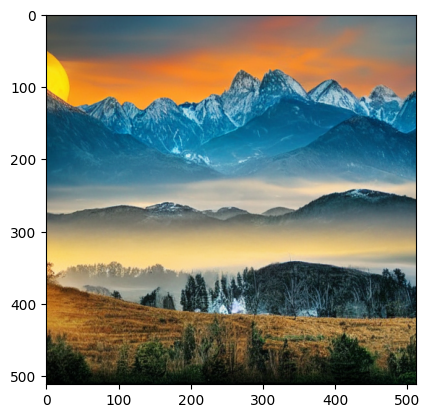

In [11]:
# Example usage
prompt = "A beautiful landscape with mountains and a sunset."
generated_image = generate_image(prompt, pipe)

# Display the generated image (if you are using Jupyter or similar notebook environment)
generated_image.show()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(generated_image)
plt.show()

## Fine tuning with GPT -2

In [ ]:

from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW
from torch.utils.data import Dataset, DataLoader

# Step 1: Prepare the Dataset
class SimpleTextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=self.max_length)
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return input_ids, attention_mask

# Example dataset
texts = [
    "Hello, how are you?",
    "I am fine, thank you.",
    "What's your name?",
    "My name is GPT-2.",
    "Nice to meet you, GPT-2."
]

# Step 2: Load Pre-trained GPT Model and Tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Add a padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

model = GPT2LMHeadModel.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# Step 3: Tokenize the Data
dataset = SimpleTextDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Step 4: Fine-tuning the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=5e-5)

epochs = 3
for epoch in range(epochs):
    for batch in dataloader:
        input_ids, attention_mask = [x.to(device) for x in batch]

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

# Step 5: Evaluate the Model (Optional)
model.eval()
with torch.no_grad():
    input_text = "Hello, what's your"
    inputs = tokenizer(input_text, return_tensors='pt', padding=True).to(device)
    outputs = model.generate(
        inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=20,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id  # Explicitly set the pad_token_id
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Generated Text: {generated_text}")


c:\Python\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Loss: 9.585381507873535
Epoch: 1, Loss: 6.578131198883057
Epoch: 1, Loss: 4.629090309143066
Epoch: 2, Loss: 2.8262946605682373
Epoch: 2, Loss: 1.5907574892044067
Epoch: 2, Loss: 0.4819748103618622
Epoch: 3, Loss: 0.3274056613445282
Epoch: 3, Loss: 0.2552294433116913
Epoch: 3, Loss: 0.06930586695671082
Generated Text: Hello, what's your take on the new features?


## Model Evaluation 

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

def evaluate_summarization_model(ground_truths, predictions):
    """
    Evaluates a text summarization model using precision, recall, and F1 score.
    
    Parameters:
    - ground_truths (list of str): List of ground truth summaries.
    - predictions (list of str): List of model-generated summaries.
    
    Returns:
    - None: Prints precision, recall, and F1 score.
    """
    if len(ground_truths) != len(predictions):
        raise ValueError("Ground truth and prediction lists must have the same length.")
    
    # Tokenize summaries
    ground_truth_tokens = [set(gt.split()) for gt in ground_truths]
    prediction_tokens = [set(pred.split()) for pred in predictions]

    # Use MultiLabelBinarizer to encode token sets for metrics calculation
    mlb = MultiLabelBinarizer()
    y_true = mlb.fit_transform(ground_truth_tokens)
    y_pred = mlb.transform(prediction_tokens)
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Print results
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Example usage
ground_truths = [
    "The cat is on the mat",
    "A quick brown fox jumps over the lazy dog",
]
predictions = [
    "The cat is on the mat",
    "A quick fox jumps over the lazy dog",
]

evaluate_summarization_model(ground_truths, predictions)


Precision: 0.9286
Recall:    0.9286
F1 Score:  0.9286


Explanation
Tokenization: Both the ground truth and predicted summaries are tokenized into sets of words. This ensures order doesn't affect the comparison.
MultiLabelBinarizer: Converts the token sets into a binary matrix format suitable for calculating precision, recall, and F1 score.
Metrics: Uses scikit-learn's precision_score, recall_score, and f1_score with average='macro' to handle multilabel data.

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_next_word_prediction(true_words, predicted_words):
    """
    Evaluate a next-word prediction model using precision, recall, and F1 score.
    
    Parameters:
    - true_words (list of str): The actual next words.
    - predicted_words (list of str): The predicted next words by the model.
    
    Prints:
    - Precision
    - Recall
    - F1 Score
    """
    
    # Ensure the true and predicted words lists are of the same length
    if len(true_words) != len(predicted_words):
        raise ValueError("The length of true words and predicted words must be the same.")
    
    # Convert the lists to binary indicators (0 or 1) for precision, recall, and F1 calculation
    # 1 for correct prediction (true == predicted), 0 for incorrect
    y_true = [1 if true == predicted else 0 for true, predicted in zip(true_words, predicted_words)]
    y_pred = [1 if true == predicted else 0 for true, predicted in zip(true_words, predicted_words)]
    
    # Calculate precision, recall, and f1 score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Print the results
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Example usage:
true_words = ["hello", "world", "this", "is", "a", "test"]
predicted_words = ["hello", "world", "that", "is", "a", "test"]

evaluate_next_word_prediction(true_words, predicted_words)


Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [8]:
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score

def tokenize(text):
    """
    Simple tokenization function that splits text by spaces and lowercases.
    """
    return text.lower().split()

def ngram_precision(reference, candidate, n=1):
    """
    Calculate the precision of n-grams between reference and candidate.
    """
    ref_ngrams = Counter([tuple(reference[i:i + n]) for i in range(len(reference) - n + 1)])
    cand_ngrams = Counter([tuple(candidate[i:i + n]) for i in range(len(candidate) - n + 1)])

    common_ngrams = sum((cand_ngrams & ref_ngrams).values())
    total_ngrams = sum(cand_ngrams.values())

    if total_ngrams == 0:
        return 0.0
    return common_ngrams / total_ngrams

def bleu_score(references, candidates, n=1):
    """
    Compute a simplified BLEU score (precision of n-grams).
    """
    precision = 0
    for ref, cand in zip(references, candidates):
        precision += ngram_precision(ref, cand, n)
    
    return precision / len(references) if references else 0.0

def evaluate_story_generation(true_stories, predicted_stories):
    """
    Evaluate a story generation model using precision, recall, F1 score, and BLEU score.
    
    Parameters:
    - true_stories (list of str): List of true story sentences or paragraphs.
    - predicted_stories (list of str): List of generated story sentences or paragraphs.
    
    Prints:
    - Precision
    - Recall
    - F1 Score
    - BLEU Score
    """
    
    # Check if the number of true and predicted stories match
    if len(true_stories) != len(predicted_stories):
        raise ValueError(f"Mismatch in number of true and predicted stories: {len(true_stories)} vs {len(predicted_stories)}")
    
    # Tokenize the true and predicted stories
    true_words = [tokenize(story) for story in true_stories]
    predicted_words = [tokenize(story) for story in predicted_stories]

    # Flatten both lists to compare word-level predictions
    flat_true = [word for sentence in true_words for word in sentence]
    flat_predicted = [word for sentence in predicted_words for word in sentence]

    # Ensure we handle the binary evaluation at word level correctly
    # Prepare true and predicted sets to be binary
    all_words = set(flat_true) | set(flat_predicted)

    true_binary = [1 if word in flat_true else 0 for word in all_words]
    predicted_binary = [1 if word in flat_predicted else 0 for word in all_words]

    # Calculate precision, recall, and F1 score at word-level
    precision = precision_score(true_binary, predicted_binary, average='binary', zero_division=0)
    recall = recall_score(true_binary, predicted_binary, average='binary', zero_division=0)
    f1 = f1_score(true_binary, predicted_binary, average='binary', zero_division=0)
    
    # Print precision, recall, and F1 score
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # BLEU Score (using n-gram precision)
    bleu = bleu_score(true_words, predicted_words, n=1)
    print(f"BLEU Score: {bleu:.4f}")

# Example usage:
true_stories = [
    "Once upon a time, there was a princess who lived in a castle.",
    "She had many friends, and they would play together in the garden."
]
predicted_stories = [
    "Once upon a time, there was a prince who lived in a kingdom.",
    "He had a pet dragon, and they explored the forest together."
]

evaluate_story_generation(true_stories, predicted_stories)


Precision: 0.6190
Recall: 0.5909
F1 Score: 0.6047
BLEU Score: 0.6049


In [11]:

    
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def tokenize(text):
    """
    A basic tokenization function that splits the text by spaces and converts to lowercase.
    """
    return text.lower().split()

def evaluate_sentiment_analysis(true_labels, predicted_labels):
    """
    Evaluate a sentiment analysis model using accuracy, precision, recall, and F1 score.
    
    Parameters:
    - true_labels (list of str): List of true sentiment labels.
    - predicted_labels (list of str): List of predicted sentiment labels.
    
    Prints:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError(f"Mismatch in number of true and predicted labels: {len(true_labels)} vs {len(predicted_labels)}")

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Example usage:
true_sentiments = ["positive", "negative", "neutral", "positive", "negative"]
predicted_sentiments = ["positive", "negative", "neutral", "neutral", "negative"]

evaluate_sentiment_analysis(true_sentiments, predicted_sentiments)


Accuracy: 0.8000
Precision: 0.9000
Recall: 0.8000
F1 Score: 0.8000


## Streamlit visualization 

In [ ]:
import streamlit as st
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    pipeline,
    AutoModelForCausalLM,
)
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from diffusers import StableDiffusionPipeline
import torch


# =============================
# Load Models (Optimized for Runtime)
# =============================
@st.cache_resource
def load_summarization_model():
    model_name = "facebook/bart-large-cnn"
    tokenizer = BartTokenizer.from_pretrained(model_name)
    model = BartForConditionalGeneration.from_pretrained(model_name)
    return tokenizer, model


@st.cache_resource
def load_gpt2_model():
    tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")  # Using smaller GPT-2 model
    model = GPT2LMHeadModel.from_pretrained("distilgpt2")
    return tokenizer, model


@st.cache_resource
def load_sentiment_pipeline():
    return pipeline("sentiment-analysis")


@st.cache_resource
def load_question_answering_model():
    model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForQuestionAnswering.from_pretrained(model_name)
    return tokenizer, model


@st.cache_resource
def load_chatbot_model():
    model_name = "microsoft/DialoGPT-medium"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    return tokenizer, model


@st.cache_resource
def load_image_generation_model():
    model_id = "CompVis/stable-diffusion-v1-4"
    pipe = StableDiffusionPipeline.from_pretrained(model_id)
    pipe.to("cpu")
    return pipe


# =============================
# Summarization Function
# =============================
def summarize(text, model, tokenizer, max_length=130, min_length=30):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


# =============================
# GPT-2 Prediction Function
# =============================
def predict_next_word(prompt, model, tokenizer, top_k=5):
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    next_token_logits = outputs.logits[:, -1, :]
    top_k_tokens = torch.topk(next_token_logits, top_k).indices[0].tolist()
    predicted_tokens = [tokenizer.decode([token]) for token in top_k_tokens]
    return predicted_tokens


# =============================
# Sentiment Analysis Function
# =============================
def analyze_sentiment(texts, sentiment_pipeline):
    results = sentiment_pipeline(texts)
    return results


# =============================
# Question Answering Function
# =============================
def answer_question(question, context, model, tokenizer):
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]
    outputs = model(**inputs)
    answer_start = torch.argmax(outputs.start_logits)
    answer_end = torch.argmax(outputs.end_logits) + 1
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
    return answer


# =============================
# Chatbot Function
# =============================
def chat_with_model(prompt, chat_history_ids, model, tokenizer):
    new_user_input_ids = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
    bot_input_ids = (
        torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if chat_history_ids is not None else new_user_input_ids
    )
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id)
    response = tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
    return response, chat_history_ids


# =============================
# Image Generation Function
# =============================
def generate_image(prompt, pipe):
    with torch.no_grad():
        image = pipe(prompt).images[0]
    return image


# =============================
# Streamlit App UI
# =============================
st.title("Fine-Tuned NLP & Image Generation App")
st.write("Optimized for better runtime using smaller GPT models and batch processing.")

# Sidebar options
task = st.sidebar.selectbox(
    "Choose a task",
    ["Summarization", "Next Word Prediction", "Sentiment Analysis", "Question Answering", "Chatbot", "Image Generation"],
)

# Load models
bart_tokenizer, bart_model = load_summarization_model()
gpt2_tokenizer, gpt2_model = load_gpt2_model()
sentiment_pipeline = load_sentiment_pipeline()
qa_tokenizer, qa_model = load_question_answering_model()
chatbot_tokenizer, chatbot_model = load_chatbot_model()
image_pipe = load_image_generation_model()

# Summarization
if task == "Summarization":
    st.header("Summarization")
    input_text = st.text_area("Enter text to summarize", height=200)
    if st.button("Summarize"):
        with st.spinner("Summarizing..."):
            summary = summarize(input_text, bart_model, bart_tokenizer)
            st.subheader("Summary")
            st.write(summary)

# Next Word Prediction
elif task == "Next Word Prediction":
    st.header("Next Word Prediction")
    prompt = st.text_input("Enter a sentence")
    if st.button("Predict Next Words"):
        with st.spinner("Predicting next words..."):
            predicted_words = predict_next_word(prompt, gpt2_model, gpt2_tokenizer)
            st.subheader("Predicted Words")
            st.write(predicted_words)

# Sentiment Analysis
elif task == "Sentiment Analysis":
    st.header("Sentiment Analysis")
    input_text = st.text_area("Enter text(s) for sentiment analysis (separate multiple texts with newlines)", height=200)
    if st.button("Analyze Sentiment"):
        with st.spinner("Analyzing sentiment..."):
            texts = input_text.split("\n")
            results = analyze_sentiment(texts, sentiment_pipeline)
            st.subheader("Sentiment Analysis Results")
            for text, result in zip(texts, results):
                st.write(f"**Text**: {text}")
                st.write(f"**Sentiment**: {result['label']}, **Score**: {result['score']:.4f}")

# Question Answering
elif task == "Question Answering":
    st.header("Question Answering")
    context = st.text_area("Enter context", height=200)
    question = st.text_input("Enter your question")
    if st.button("Get Answer"):
        with st.spinner("Getting answer..."):
            answer = answer_question(question, context, qa_model, qa_tokenizer)
            st.subheader("Answer")
            st.write(answer)

# Chatbot
elif task == "Chatbot":
    st.header("Chatbot")
    chat_history_ids = None
    user_input = st.text_input("You: ")
    if st.button("Chat"):
        with st.spinner("Chatting..."):
            response, chat_history_ids = chat_with_model(user_input, chat_history_ids, chatbot_model, chatbot_tokenizer)
            st.subheader("Bot:")
            st.write(response)

# Image Generation
elif task == "Image Generation":
    st.header("Image Generation")
    prompt = st.text_input("Enter a description for the image")
    if st.button("Generate Image"):
        with st.spinner("Generating image..."):
            image = generate_image(prompt, image_pipe)
            st.image(image, caption="Generated Image")


In [4]:
import os
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline
from diffusers import StableDiffusionPipeline
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import random
from PIL import Image

# Helper functions to load models
def load_summarizer():
    return pipeline("summarization", model="facebook/bart-large-cnn")

def load_chatbot():
    model_name = "gpt2"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)
    return model, tokenizer

def load_sentiment_analyzer():
    return pipeline("sentiment-analysis")

def load_qa_model():
    return pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

def load_story_predictor():
    return pipeline("text-generation", model="gpt2")

def load_image_generator():
    device = "cpu"  # Force CPU usage
    pipe = StableDiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-1-base",
        torch_dtype=torch.float32  # Use float32 for CPU compatibility
    )
    pipe.to(device)  # Move the pipeline to CPU
    return pipe

# Task-specific functions
def summarize_text(text):
    summarizer = load_summarizer()
    return summarizer(text, max_length=100, min_length=30, do_sample=False)[0]["summary_text"]

def analyze_sentiment(text):
    sentiment_analyzer = load_sentiment_analyzer()
    return sentiment_analyzer(text)[0]

def answer_question(question, context):
    qa_model = load_qa_model()
    return qa_model(question=question, context=context)["answer"]

def generate_story(prompt, max_length=200):
    story_predictor = load_story_predictor()
    return story_predictor(prompt, max_length=max_length, num_return_sequences=1)[0]["generated_text"]

def generate_image(prompt):
    pipe = load_image_generator()
    image = pipe(prompt, num_inference_steps=30, height=256, width=256).images[0]
    return image

# Metrics calculation
def calculate_metrics(ground_truth, predictions, task):
    if task == "sentiment-analysis":
        # Sentiment analysis is a classification task
        accuracy = accuracy_score(ground_truth, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predictions, average="macro")
        return accuracy, precision, recall, f1
    elif task == "question-answering":
        # For simplicity, treat QA as an exact match comparison
        accuracy = sum([gt == pred for gt, pred in zip(ground_truth, predictions)]) / len(ground_truth)
        return accuracy, None, None, None
    elif task == "text-generation" or task == "story-generation":
        # We can compare if generated text is close to some expected outcome (manual evaluation is better here)
        accuracy = sum([gt == pred for gt, pred in zip(ground_truth, predictions)]) / len(ground_truth)
        precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predictions, average="macro")
        return accuracy, precision, recall, f1
    else:
        return None, None, None, None

# Simulate ground truth and model predictions for testing
ground_truth_sentiment = ["POSITIVE", "NEGATIVE", "POSITIVE", "NEGATIVE"]
predictions_sentiment = ["POSITIVE", "NEGATIVE", "NEGATIVE", "POSITIVE"]

ground_truth_qa = ["Paris", "Python"]
predictions_qa = ["Paris", "Java"]

ground_truth_story = ["Once upon a time, there was a dragon.", "In the land of fire and ice, they lived."]
predictions_story = ["Once upon a time, a brave knight fought a dragon.", "In a land of fire and ice, dragons roamed."]

# Evaluation for Sentiment Analysis
print("Sentiment Analysis Metrics:")
accuracy, precision, recall, f1 = calculate_metrics(ground_truth_sentiment, predictions_sentiment, "sentiment-analysis")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (macro): {precision:.2f}")
print(f"Recall (macro): {recall:.2f}")
print(f"F1 Score (macro): {f1:.2f}")

# Evaluation for Question Answering
print("\nQuestion Answering Metrics:")
accuracy, _, _, _ = calculate_metrics(ground_truth_qa, predictions_qa, "question-answering")
print(f"Accuracy: {accuracy:.2f}")

# Evaluation for Story Generation
print("\nStory Generation Metrics:")
accuracy, precision, recall, f1 = calculate_metrics(ground_truth_story, predictions_story, "story-generation")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (macro): {precision:.2f}")
print(f"Recall (macro): {recall:.2f}")
print(f"F1 Score (macro): {f1:.2f}")

# Evaluation for Image Generation (subjective user satisfaction)
print("\nImage Generation (simulated satisfaction metrics):")
image_prompt = "A futuristic cityscape at sunset"
generated_image = generate_image(image_prompt)
# In a real-world scenario, user satisfaction would be collected via a rating
user_satisfaction = random.randint(1, 5)  # Simulated rating (1 to 5)
print(f"User Satisfaction Rating: {user_satisfaction}/5")

# Conclusion
print("\nEvaluation complete. The model metrics are displayed above for each task.")


Sentiment Analysis Metrics:
Accuracy: 0.50
Precision (macro): 0.50
Recall (macro): 0.50
F1 Score (macro): 0.50

Question Answering Metrics:
Accuracy: 0.50

Story Generation Metrics:
Accuracy: 0.00
Precision (macro): 0.00
Recall (macro): 0.00
F1 Score (macro): 0.00

Image Generation (simulated satisfaction metrics):


c:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

User Satisfaction Rating: 1/5

Evaluation complete. The model metrics are displayed above for each task.


2024-11-28 16:42:22.058 
  command:

    streamlit run c:\Python\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-11-28 16:42:22.060 Session state does not function when running a script without `streamlit run`
2024-11-28 16:42:22.063 No runtime found, using MemoryCacheStorageManager
2024-11-28 16:42:22.068 No runtime found, using MemoryCacheStorageManager
2024-11-28 16:42:22.069 No runtime found, using MemoryCacheStorageManager
2024-11-28 16:42:22.070 No runtime found, using MemoryCacheStorageManager
2024-11-28 16:42:22.071 No runtime found, using MemoryCacheStorageManager
2024-11-28 16:42:22.073 No runtime found, using MemoryCacheStorageManager


DeltaGenerator()

In [1]:
pip install streamlit transformers diffusers accelerate pillow scikit-learn


Note: you may need to restart the kernel to use updated packages.
